In [56]:
import pandas as pd
from preprocess import load_data_year
import seaborn as sns

In [60]:
# Load data
data = load_data_year(1995)
data.head(100)

,Date,CAMEOCode,NumEvents,NumArts,Goldstein,Source code,Target code
0,1995-01-01,36,1,1,4.0,AFG,AFG
1,1995-01-01,40,1,9,1.0,AFG,AFG
2,1995-01-01,90,1,4,-2.0,AFG,AFG
3,1995-01-01,36,1,1,4.0,AFG,AFG
4,1995-01-01,40,1,9,1.0,AFG,AFG
...,...,...,...,...,...,...,...
95,1995-01-01,20,1,6,3.0,GBR,KNA
96,1995-01-01,43,1,2,2.8,GBR,GBR
97,1995-01-01,42,4,15,1.9,GBR,JOR
98,1995-01-01,42,3,15,1.9,GBR,JOR


<AxesSubplot: xlabel='Goldstein', ylabel='Target code'>

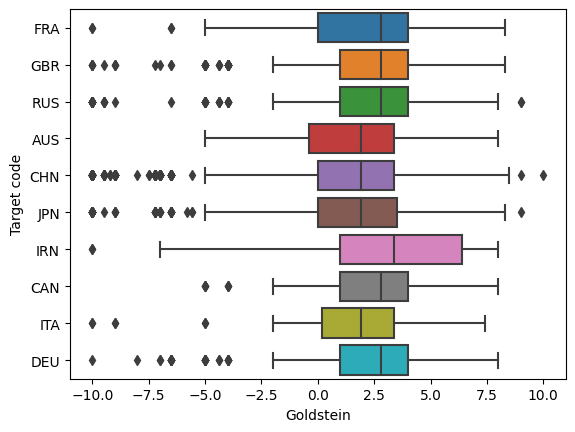

In [61]:
# Take USA data
target_countries = ['IRN', 'RUS', 'CHN', 'GBR', 'FRA', 'DEU', 'JPN', 'ITA', 'CAN', 'AUS']
usa_data = data[data['Source code'] == 'CHN']
usa_data = usa_data[usa_data['Target code'].isin(target_countries)]
sns.boxplot(usa_data, x='Goldstein', y='Target code')